In [1]:
import numpy as np
import matplotlib.pyplot as plt

from discrepancies import mmd
from kernels import PolynomialKernel, GaussianKernel, LaplacianKernel

In [2]:
np.random.seed(0)

# Maximum Mean Discrepancy

The Maximum Mean Discrepancy (MMD) is given by:
$$MMD^2[\mathcal{H}, X, Y] =  \mathbb{E}_{X, \tilde{X} \sim \mathbb{P}}[k(X,\tilde{X})]-2\mathbb{E}_{X \sim \mathbb{P},Y \sim \mathbb{Q}}[k(X,Y)]+\mathbb{E}_{Y, \tilde{Y} \sim \mathbb{Q}}[k(Y,\tilde{Y})]$$

(Eq. 3.30)

An unbiased estimate of MMD:
$$\hat{MMD}^2[\mathcal{H}, X, Y] = \frac{1}{m(m-1)}\sum_{i=1}^{m}\sum_{j\neq i}^{m}k(x_i, x_j)+\frac{1}{n(n-1)}\sum_{i=1}^{n}\sum_{j\neq i}^{n}k(y_i, y_j)-\frac{2}{mn}\sum_{i=1}^{m}\sum_{j=1}^{n}k(x_i, y_j)$$

(Eq. 3.32)

# Polynomial Kernels

Here we compare samples from normal distributions of the same mean but different covariances. We can see that for kernels of degree one, the MMD values do not change significantly despite the distributions being compared having different variances.  This is because a linear kernel retains only the first moments of the distributions. However, as we increase the degree of the polynomial kernel, higher moments of the distribution are retained by the kernel mean embedding, and the differences in covariances is reflected in the MMD.

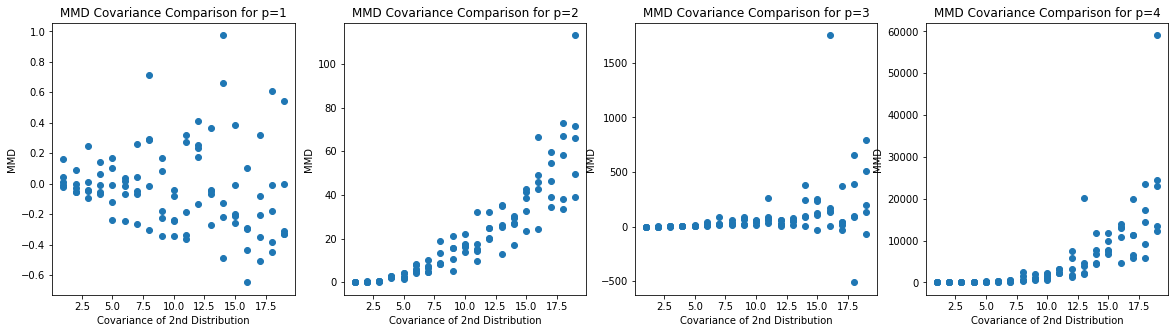

In [3]:
n_dimensions = 5
n_samples = 25
n_trials = 5
sigma = 0.1
m, n = 30, 30
n_polynomials = 4
covariance_scales = np.arange(1, 20)

mu_x = np.zeros(n_dimensions)
covariance_x = np.eye(n_dimensions)
mu_y = np.zeros(n_dimensions)

fig, axs = plt.subplots(1, n_polynomials)
fig.set_figheight(5)
fig.set_figwidth(20)

for i, p in enumerate(np.arange(1, n_polynomials + 1)):
    X, MMDs = [], []
    for covariance_scale in covariance_scales:
        covariance_y = covariance_scale * np.eye(n_dimensions)
        X.extend([covariance_scale] * n_trials)
        MMDs.extend(
            [
                mmd(
                    kernel=PolynomialKernel(p),
                    x=np.random.multivariate_normal(mu_x, covariance_x, n_samples),
                    y=np.random.multivariate_normal(mu_y, covariance_y, n_samples),
                )
                for _ in range(n_trials)
            ]
        )
    axs[i].scatter(X, MMDs)
    axs[i].set_title(f"MMD Covariance Comparison for p={p}")
    axs[i].set_xlabel("Covariance of 2nd Distribution")
    axs[i].set_ylabel("MMD")

On the other hand, when shifting the mean of the distribution, all polynomial kernels will pick this up as this shift changes the first moment of the distribution. 

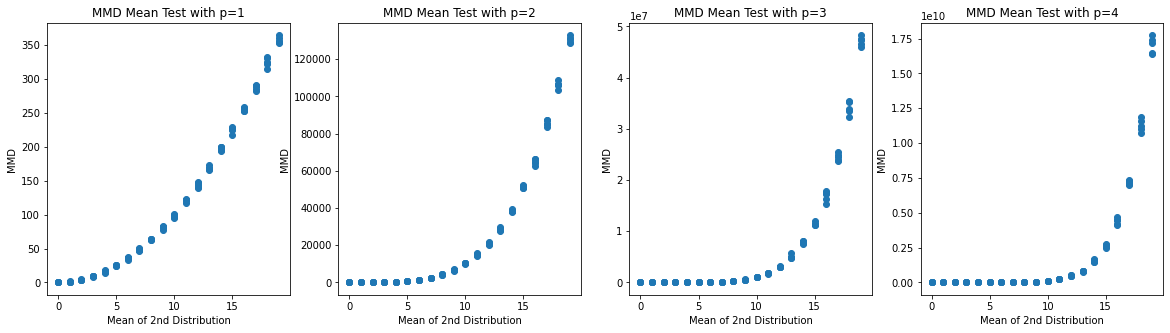

In [4]:
n_dimensions = 5
n_samples = 25
n_trials = 5
sigma = 0.1
m, n = 30, 30
n_polynomials = 4
mu_shifts = np.arange(0, 20)

mu_x = np.zeros(n_dimensions)
covariance_x = np.eye(n_dimensions)
covariance_y = np.eye(n_dimensions)

fig, axs = plt.subplots(1, n_polynomials)
fig.set_figwidth(20)
fig.set_figheight(5)
for i, p in enumerate(np.arange(1, n_polynomials + 1)):
    X, MMDs = [], []
    for mu_shift in mu_shifts:
        mu_y = np.zeros(n_dimensions) + mu_shift
        X.extend([mu_shift] * n_trials)
        MMDs.extend(
            [
                mmd(
                    kernel=PolynomialKernel(p),
                    x=np.random.multivariate_normal(mu_x, covariance_x, n_samples),
                    y=np.random.multivariate_normal(mu_y, covariance_y, n_samples),
                )
                for _ in range(n_trials)
            ]
        )
    axs[i].scatter(X, MMDs)
    axs[i].set_title(f"MMD Mean Test with p={p}")
    axs[i].set_xlabel("Mean of 2nd Distribution")
    axs[i].set_ylabel("MMD")

This motivates the intuition for using an exponential type kernel, which when decomposed, is the power series. By incoporating all possible moments of the signal (distribution), the kernel can be interpreted as a transformation into the Fourier domain. As a Fourier type transform, this also ensures that the kernel is injective (i.e. there is no information loss), maintaining the property $k(X,Y)=0 \Leftrightarrow X = Y$.

# Convergence of $\hat{MMD}$

The emirical MMD is described to converge at a rate of $\mathcal{O}(n^{-1/2})$. By increasing the number of samples taken from two Gaussian distributions, we can see this in action. Because the MMD will be compared between two sets of samples from the same normal distribution, we know that the actual MMD is zero. Thus the absolute value of the empirical MMD can be taken directly as the discrepancy $e = |\hat{MMD}-MMD| = |\hat{MMD}|$. To plot an upper bound line for $\mathcal{O}(n^{-1/2})$, 3 standard deviations are taken for the set of empirical MMD values for 2 sample points to scale the $n^{-1/2}$ function. 

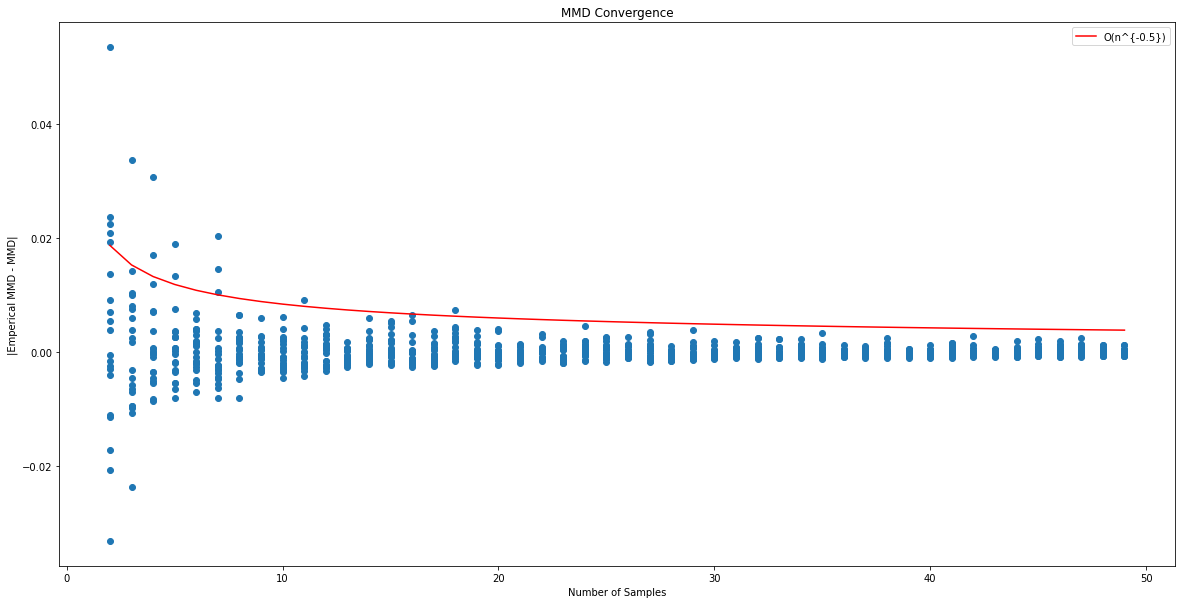

In [5]:
n_dimensions = 3
sigma = 1e-2
mu = np.zeros(n_dimensions)
n_trials = 20
X = []
MMDs = []
max_n_sample = 50
for n_sample in range(2, max_n_sample):
    X.extend([n_sample] * n_trials)
    MMDs.extend(
        [
            mmd(
                kernel=LaplacianKernel(sigma),
                x=np.random.multivariate_normal(
                    mu, np.eye(n_dimensions, n_dimensions), n_sample
                ),
                y=np.random.multivariate_normal(
                    mu, np.eye(n_dimensions, n_dimensions), n_sample
                ),
            )
            for _ in range(n_trials)
        ]
    )

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
fig.set_figwidth(20)
fig.set_figheight(10)

bound_x = np.arange(2, max_n_sample)
ax.plot(
    bound_x,
    np.std(MMDs[:n_trials]) * np.sqrt(2) / np.sqrt(bound_x),
    "r",
    label="O(n^{-0.5})",
)
plt.scatter(X, MMDs)

ax.set_title(f"MMD Convergence")
ax.set_xlabel("Number of Samples")
ax.set_ylabel("|Emperical MMD - MMD|")
ax.legend()
plt.show()

We can see qualitatively see that this suggests that  $\mathcal{O}(n^{-1/2})$ is a reasonable bound for the empirical MMD.

# MNIST Dataset Example

The MMD can be used on data for which the data generating distribution is unknown. As an example, we can use the MNIST dataset to compare images from the same digit as if they are "samples" from the same underlying distribution for that digit. 

In [6]:
from sklearn.datasets import fetch_openml

In [7]:
mnist = fetch_openml("mnist_784")
x = np.array(mnist.data)
y = mnist.target

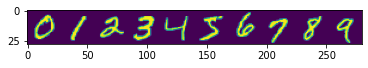

In [8]:
plt.imshow(
    np.stack(
        [x[y == str(i)][0, :].reshape((28, 28)) for i in range(10)], axis=1
    ).reshape((28, 28 * 10))
)
plt.show()

We can visualise a heatmap of the MMDs for samples from different digits. 

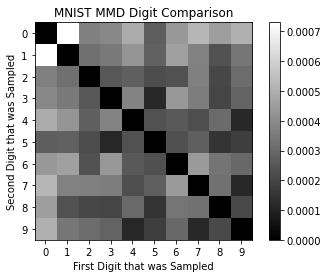

In [9]:
mnist_mmd_gauss = np.zeros((10, 10))
n_samples = 100
sigma = 1e-10
gaussian_kernel = GaussianKernel(sigma)
for i in range(10):
    a = x[y == str(i)][:n_samples]
    for j in range(10):
        if i == j:
            b = x[y == str(j)][n_samples : 2 * n_samples]
        else:
            b = x[y == str(j)][:n_samples]
            mnist_mmd_gauss[i, j] = mmd(gaussian_kernel, a, b)

fig, ax = plt.subplots(1, 1)
plt.imshow(mnist_mmd_gauss, cmap="gray")
ax.set_title(f"MNIST MMD Digit Comparison")
ax.set_xlabel("First Digit that was Sampled")
ax.set_ylabel("Second Digit that was Sampled")
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
plt.colorbar()
plt.show()

Samples from the same digit have much lower MMDs (the diagonal). We can see higher MMDs when comparing digits that are not as similar when written, such as 0 and 1. On the hand, more similar digits like 7 and 9 have lower MMDs.